# Classifying Heritage Elements

This notebook contains the analysis and classification of the architectural heritage elements dataset.

Dataset acquired from https://old.datahub.io/dataset/architectural-heritage-elements-image-dataset

In [2]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from keras_preprocessing import image
from keras.models import Sequential, Model, load_model
from keras import metrics
from keras.applications import resnet, resnet_v2, densenet, mobilenet, mobilenet_v2
from keras.layers import Input, Flatten, Dense, Dropout, Convolution2D, Conv2D, MaxPooling2D, AveragePooling2D, Lambda, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation, AveragePooling2D, Concatenate, ZeroPadding2D, ReLU, DepthwiseConv2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from keras import regularizers
from keras.constraints import max_norm, min_max_norm

Using TensorFlow backend.


In [3]:
SEED = 1
CATEGORIES = ['altar','apse','bell_tower','column','dome(inner)','dome(outer)','flying_buttress','gargoyle',
              'stained_glass','vault']
NUM_CATEGORIES = len(CATEGORIES)

## Looking at the Data

The train dataset consists of 128x128 images

In [4]:
train_dir = 'data/train'
test_dir = 'data/test'

In [5]:
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

altar 829 images
apse 514 images
bell_tower 1059 images
column 1919 images
dome(inner) 616 images
dome(outer) 1177 images
flying_buttress 407 images
gargoyle 1571 images
stained_glass 1033 images
vault 1110 images


There's a disparity in the number of examples per category. Flying buttresses have the least number of images (407), while gargoyle images are more than thrice that number at 1571.

In [6]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['data/train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.head()

,file,category_id,category
0,data/train/altar/7847845622_b7dbd200bc_m.jpg,0,altar
1,data/train/altar/1795688918_800ff98377_m.jpg,0,altar
2,data/train/altar/5543356602_7c2c25239b_n.jpg,0,altar
3,data/train/altar/2166394829_94c77390b1_m.jpg,0,altar
4,data/train/altar/5154728635_a67566ecb2_m.jpg,0,altar


In [7]:
train.shape

(10235, 3)

In [8]:
def read_img(filepath, size):
    img = image.load_img(filepath, target_size=size)
    img = image.img_to_array(img)
    return img

In [9]:
X = []
y = train['category_id']
for filepath in train['file'].values:
    img=read_img(filepath, (64,64))
    X.append(img)

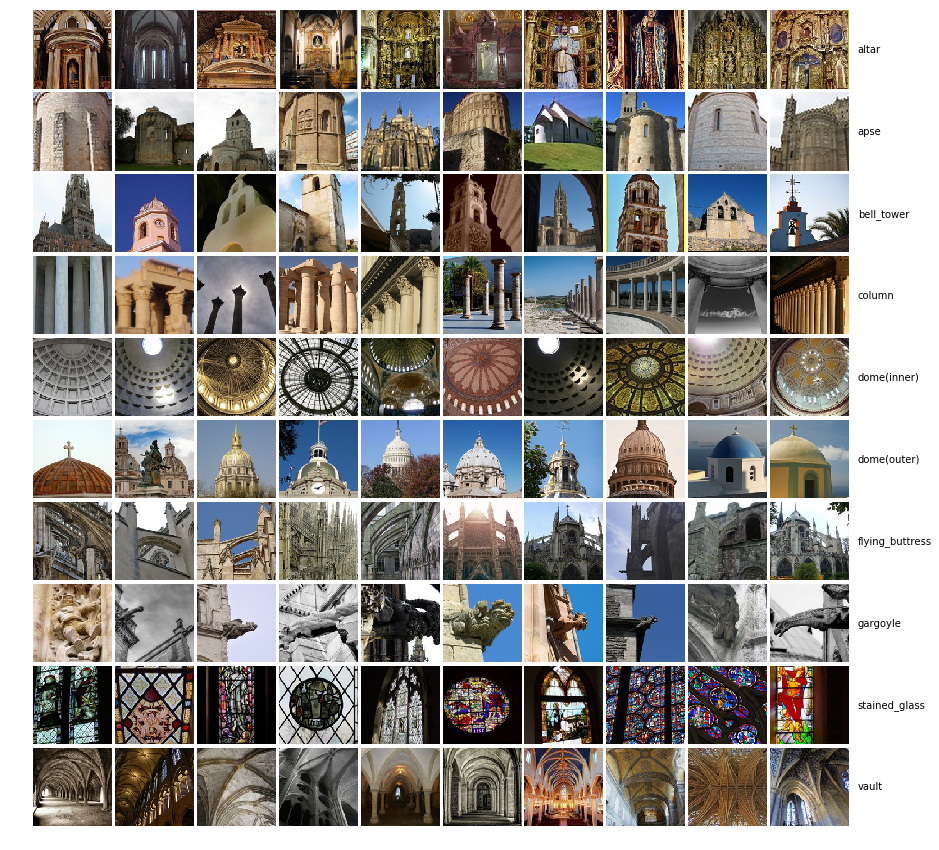

In [8]:
fig = plt.figure(1, figsize=(15, 15))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)
i = 0
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (224, 224))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[2], verticalalignment='center')
        i += 1
plt.show();

## Image Pre-processing

Resizing the data to improve training time and match test image sizes, which are 64x64

Augment data by flipping them horizontally

In [48]:
datagen = image.ImageDataGenerator(horizontal_flip=True, validation_split=0.2, 
                                   preprocessing_function=resnet.preprocess_input)
train_generator=datagen.flow_from_dataframe(dataframe=train, directory=None, 
                                                x_col="file", y_col="category", shuffle=True, seed=SEED,
                                                class_mode="sparse", target_size=(64,64), batch_size=32, 
                                                  subset="training")
valid_generator=datagen.flow_from_dataframe(dataframe=train, directory=None, 
                                                x_col="file", y_col="category", shuffle=True, seed=SEED,
                                                class_mode="sparse", target_size=(64,64), batch_size=32, 
                                                  subset="validation")

Found 8188 validated image filenames belonging to 10 classes.
Found 2047 validated image filenames belonging to 10 classes.


## Selecting Models

Pre-trained keras moodels for image classification with weights trained on ImageNet:

- ResNet50
- ResNet50V2
- DenseNet201
- DenseNet169

These models were selected because they accepted the input size.

In [24]:
base_model = resnet.ResNet50(weights='imagenet', include_top=False, input_shape =(64,64,3))
x = GlobalAveragePooling2D(name='avg_pool')(base_model.output)
x = Dropout(0.4)(x)
predictions = Dense(NUM_CATEGORIES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs = predictions)
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(lr=0.001), metrics=['accuracy'])

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 4d473c1dd8becc155b73f8504c6f6626 so we will re-download the data.
94773248/94765736 [==============================] - 45s 0us/step


In [26]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=4)

Epoch 1/4
255/255 [==============================] - 905s 4s/step - loss: 1.4875 - acc: 0.6175 - val_loss: 4.4968 - val_acc: 0.0015
Epoch 2/4
255/255 [==============================] - 874s 3s/step - loss: 0.5983 - acc: 0.8253 - val_loss: 5.5408 - val_acc: 0.1136
Epoch 3/4
255/255 [==============================] - 873s 3s/step - loss: 0.6627 - acc: 0.8346 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 4/4
255/255 [==============================] - 872s 3s/step - loss: 1.6502 - acc: 0.5748 - val_loss: 9.5743 - val_acc: 4.9628e-04


#### ResNet50V2

In [33]:
datagen = image.ImageDataGenerator(horizontal_flip=True, validation_split=0.2, 
                                   preprocessing_function=resnet_v2.preprocess_input)
train_generator=datagen.flow_from_dataframe(dataframe=train, directory=None, 
                                                x_col="file", y_col="category", shuffle=True, seed=SEED,
                                                class_mode="sparse", target_size=(64,64), batch_size=32, 
                                                  subset="training")
valid_generator=datagen.flow_from_dataframe(dataframe=train, directory=None, 
                                                x_col="file", y_col="category", shuffle=True, seed=SEED,
                                                class_mode="sparse", target_size=(64,64), batch_size=32, 
                                                  subset="validation")

base_model = resnet_v2.ResNet50V2(weights='imagenet', include_top=False, input_shape =(64,64,3))
x = GlobalAveragePooling2D(name='avg_pool')(base_model.output)
x = Dropout(0.4)(x)
predictions = Dense(NUM_CATEGORIES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs = predictions)
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(lr=0.001), metrics=['accuracy'])

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=4)

Found 8188 validated image filenames belonging to 10 classes.
Found 2047 validated image filenames belonging to 10 classes.
94674944/94668760 [==============================] - 70s 1us/step
Epoch 1/4
255/255 [==============================] - 884s 3s/step - loss: 1.1693 - acc: 0.7070 - val_loss: 13.8027 - val_acc: 0.0000e+00
Epoch 2/4
255/255 [==============================] - 780s 3s/step - loss: 1.1391 - acc: 0.7484 - val_loss: 13.7052 - val_acc: 0.0000e+00
Epoch 3/4
255/255 [==============================] - 775s 3s/step - loss: 1.2141 - acc: 0.7146 - val_loss: 4.3690 - val_acc: 0.0000e+00
Epoch 4/4
255/255 [==============================] - 764s 3s/step - loss: 1.1931 - acc: 0.7228 - val_loss: 4.7360 - val_acc: 0.0000e+00


#### DenseNet121

In [9]:
datagen = image.ImageDataGenerator(horizontal_flip=True, validation_split=0.2, 
                                   preprocessing_function=densenet.preprocess_input)
train_generator=datagen.flow_from_dataframe(dataframe=train, directory=None, 
                                                x_col="file", y_col="category", shuffle=True, seed=SEED,
                                                class_mode="sparse", target_size=(64,64), batch_size=32, 
                                                  subset="training")
valid_generator=datagen.flow_from_dataframe(dataframe=train, directory=None, 
                                                x_col="file", y_col="category", shuffle=True, seed=SEED,
                                                class_mode="sparse", target_size=(64,64), batch_size=32, 
                                                  subset="validation")

base_model = densenet.DenseNet121(weights='imagenet', include_top=False, input_shape =(64,64,3))
x = GlobalAveragePooling2D(name='avg_pool')(base_model.output)
x = Dropout(0.4)(x)
predictions = Dense(NUM_CATEGORIES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs = predictions)
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(lr=0.001), metrics=['accuracy'])

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=4)

Found 8188 validated image filenames belonging to 10 classes.
Found 2047 validated image filenames belonging to 10 classes.
Instructions for updating:
Colocations handled automatically by placer.
29089792/29084464 [==============================] - 27s 1us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/4
255/255 [==============================] - 797s 3s/step - loss: 0.7357 - acc: 0.7978 - val_loss: 14.4982 - val_acc: 4.9603e-04
Epoch 2/4
255/255 [==============================] - 754s 3s/step - loss: 0.6628 - acc: 0.7974 - val_loss: 7.1589 - val_acc: 0.1211
Epoch 3/4
255/255 [==============================] - 752s 3s/step - loss: 0.3693 - acc: 0.8828 - val_loss: 7.7976 - val_acc: 0.1444
Epoch 4/4
255/255 [==============================] - 743s 3s/step - loss: 0.2972 - acc: 0.9058 - val_loss: 7.0347 - val_acc: 0.2481


#### DenseNet169

In [10]:
datagen = image.ImageDataGenerator(horizontal_flip=True, validation_split=0.2, 
                                   preprocessing_function=densenet.preprocess_input)
train_generator=datagen.flow_from_dataframe(dataframe=train, directory=None, 
                                                x_col="file", y_col="category", shuffle=True, seed=SEED,
                                                class_mode="sparse", target_size=(64,64), batch_size=32, 
                                                  subset="training")
valid_generator=datagen.flow_from_dataframe(dataframe=train, directory=None, 
                                                x_col="file", y_col="category", shuffle=True, seed=SEED,
                                                class_mode="sparse", target_size=(64,64), batch_size=32, 
                                                  subset="validation")

base_model = densenet.DenseNet169(weights='imagenet', include_top=False, input_shape =(64,64,3))
x = GlobalAveragePooling2D(name='avg_pool')(base_model.output)
x = Dropout(0.4)(x)
predictions = Dense(NUM_CATEGORIES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs = predictions)
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(lr=0.001), metrics=['accuracy'])

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=4)

Found 8188 validated image filenames belonging to 10 classes.
Found 2047 validated image filenames belonging to 10 classes.
51879936/51877672 [==============================] - 23s 0us/step
Epoch 1/4
255/255 [==============================] - 960s 4s/step - loss: 0.6106 - acc: 0.8193 - val_loss: 6.9230 - val_acc: 0.0833
Epoch 2/4
255/255 [==============================] - 912s 4s/step - loss: 0.4970 - acc: 0.8622 - val_loss: 14.5166 - val_acc: 0.0045
Epoch 3/4
255/255 [==============================] - 948s 4s/step - loss: 0.7389 - acc: 0.7760 - val_loss: 15.3042 - val_acc: 0.0000e+00
Epoch 4/4
255/255 [==============================] - 960s 4s/step - loss: 0.8580 - acc: 0.7256 - val_loss: 8.4134 - val_acc: 0.0402


#### DenseNet201

In [74]:
datagen = image.ImageDataGenerator(horizontal_flip=True, validation_split=0.2, 
                                   preprocessing_function=densenet.preprocess_input)
train_generator=datagen.flow_from_dataframe(dataframe=train, directory=None, 
                                                x_col="file", y_col="category", shuffle=True, seed=SEED,
                                                class_mode="sparse", target_size=(64,64), batch_size=32, 
                                                  subset="training")
valid_generator=datagen.flow_from_dataframe(dataframe=train, directory=None, 
                                                x_col="file", y_col="category", shuffle=True, seed=SEED,
                                                class_mode="sparse", target_size=(64,64), batch_size=32, 
                                                  subset="validation")

base_model = densenet.DenseNet201(weights='imagenet', include_top=False, input_shape =(64,64,3))
x = GlobalAveragePooling2D(name='avg_pool')(base_model.output)
x = Dropout(0.4)(x)
predictions = Dense(NUM_CATEGORIES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs = predictions)
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(lr=0.001), metrics=['accuracy'])

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=4)

Found 8188 validated image filenames belonging to 10 classes.
Found 2047 validated image filenames belonging to 10 classes.
74842112/74836368 [==============================] - 53s 1us/step
Epoch 1/4
255/255 [==============================] - 1649s 6s/step - loss: 0.6611 - acc: 0.8050 - val_loss: 7.6009 - val_acc: 0.1091
Epoch 2/4
255/255 [==============================] - 1163s 5s/step - loss: 0.5749 - acc: 0.8281 - val_loss: 8.2629 - val_acc: 0.0526
Epoch 3/4
255/255 [==============================] - 1169s 5s/step - loss: 0.3730 - acc: 0.8775 - val_loss: 8.1273 - val_acc: 0.0988
Epoch 4/4
255/255 [==============================] - 1164s 5s/step - loss: 0.4619 - acc: 0.8598 - val_loss: 12.6517 - val_acc: 0.0099


#### Narrowing Things Down

DenseNet121 has the best results out of all the pre-trained models. Let's train it on more epochs.

In [79]:
datagen = image.ImageDataGenerator(horizontal_flip=True, brightness_range = [0.5,1.5], validation_split=0.2, 
                                   preprocessing_function=densenet.preprocess_input)
train_generator=datagen.flow_from_dataframe(dataframe=train, directory=None, 
                                                x_col="file", y_col="category", shuffle=True, seed=SEED,
                                                class_mode="sparse", target_size=(64,64), batch_size=32, 
                                                  subset="training")
valid_generator=datagen.flow_from_dataframe(dataframe=train, directory=None, 
                                                x_col="file", y_col="category", shuffle=True, seed=SEED,
                                                class_mode="sparse", target_size=(64,64), batch_size=32, 
                                                  subset="validation")

base_model =  densenet.DenseNet121(weights='imagenet', include_top=False, input_shape =(64,64,3))
x = GlobalAveragePooling2D(name='avg_pool')(base_model.output)
x = Dropout(0.4)(x)
predictions = Dense(NUM_CATEGORIES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs = predictions)
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(lr=0.001), metrics=['accuracy'])

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20)

Found 8188 validated image filenames belonging to 10 classes.
Found 2047 validated image filenames belonging to 10 classes.
Epoch 1/20
255/255 [==============================] - 883s 3s/step - loss: 0.7257 - acc: 0.8005 - val_loss: 9.1308 - val_acc: 0.0079
Epoch 2/20
255/255 [==============================] - 771s 3s/step - loss: 0.5055 - acc: 0.8519 - val_loss: 7.0193 - val_acc: 0.2069
Epoch 3/20
255/255 [==============================] - 772s 3s/step - loss: 0.2861 - acc: 0.9051 - val_loss: 8.3446 - val_acc: 0.1633
Epoch 4/20
255/255 [==============================] - 767s 3s/step - loss: 0.2135 - acc: 0.9291 - val_loss: 8.1903 - val_acc: 0.1846
Epoch 5/20
255/255 [==============================] - 751s 3s/step - loss: 0.2830 - acc: 0.9096 - val_loss: 7.1587 - val_acc: 0.2829
Epoch 6/20
255/255 [==============================] - 748s 3s/step - loss: 0.2786 - acc: 0.9137 - val_loss: 8.5734 - val_acc: 0.1801
Epoch 7/20
255/255 [==============================] - 751s 3s/step - loss: 0.2

The model is overfitting. Training accuracy is far higher than validation accuracy, the latter of which has plateaued.

I've added callbacks and used to help prevent overfitting, and trained it using cross validation.

In [9]:
def get_model():
    base_model = densenet.DenseNet121(weights='imagenet', include_top=False, input_shape =(64,64,3))
    x = GlobalAveragePooling2D(name='avg_pool')(base_model.output)
    x = Dropout(0.4)(x)
    predictions = Dense(NUM_CATEGORIES, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs = predictions)
    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), 
                  metrics=['accuracy'])
    
    return model

In [10]:
def k_fold(k):
    folds = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED).split(X, y))
    
    return folds

In [11]:
def get_callbacks(name_weights, patience_lr):
    mcp_save = ModelCheckpoint('models/'+name_weights, save_best_only=True, monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=patience_lr, verbose=1, epsilon=1e-4, mode='min')
    return [mcp_save, reduce_lr_loss]

In [12]:
datagen = image.ImageDataGenerator(horizontal_flip=True, brightness_range = [0.5,1.5], 
                                   preprocessing_function=densenet.preprocess_input)

In [13]:
batch_size = 64

In [14]:
X = np.array(X)
y = np.array(y)

In [25]:
folds = k_fold(10)
model = get_model()
for j, (train_idx, val_idx) in enumerate(folds):
    
    print('\nFold ',j)
    X_train_cv = X[train_idx]
    y_train_cv = y[train_idx]
    X_valid_cv = X[val_idx]
    y_valid_cv= y[val_idx]
    
    name_weights = "model1_" + str(j) + "_weights.h5"
    callbacks = get_callbacks(name_weights = name_weights, patience_lr=10)
    
    generator = datagen.flow(X_train_cv, y_train_cv, batch_size = batch_size)
    
    model_history = model.fit_generator(
                generator,
                steps_per_epoch=len(X_train_cv)/batch_size,
                epochs=5,
                shuffle=True,
                verbose=1,
                validation_data = (X_valid_cv, y_valid_cv),
                callbacks = callbacks)
    
    print(model.evaluate(X_valid_cv, y_valid_cv))
model.save("models/model1.h5")
print("Saved model to disk")


Fold  0


/home/isa/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/5
144/143 [==============================] - 881s 6s/step - loss: 0.6666 - acc: 0.8018 - val_loss: 9.0029 - val_acc: 0.3496
Epoch 2/5
144/143 [==============================] - 799s 6s/step - loss: 0.3313 - acc: 0.8968 - val_loss: 9.3236 - val_acc: 0.3057
Epoch 3/5
144/143 [==============================] - 798s 6s/step - loss: 0.2779 - acc: 0.9116 - val_loss: 12.4972 - val_acc: 0.2220
Epoch 4/5
144/143 [==============================] - 798s 6s/step - loss: 0.2263 - acc: 0.9254 - val_loss: 9.7823 - val_acc: 0.3340
Epoch 5/5
1027/1027 [==============================] - 20s 20ms/step
[11.56178682026865, 0.2736124634858812]

Fold  1
Epoch 1/5
144/143 [==============================] - 799s 6s/step - loss: 0.1876 - acc: 0.9410 - val_loss: 10.6011 - val_acc: 0.2904
Epoch 2/5
144/143 [==============================] - 800s 6s/step - loss: 0.1293 - acc: 0.9570 - val_loss: 10.1258 - val_acc: 0.3450
Epoch 3/5
144/143 [==============================] - 799s 6s/step - loss: 0.1379 - acc:

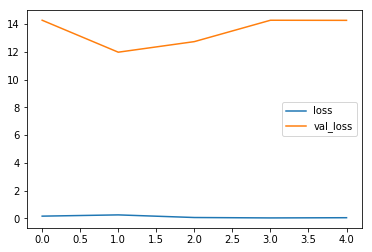

In [26]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.show()

It's still overfitting. The result is the same with the other pre-trained models. 

Let's try using a simpler model instead.

#### Custom Model

In [14]:
datagen = image.ImageDataGenerator(horizontal_flip=True, brightness_range = [0.5,1.5])

In [24]:
folds = k_fold(10)
for j, (train_idx, val_idx) in enumerate(folds):
    
    print('\nFold ',j)
    X_train_cv = X[train_idx]
    y_train_cv = y[train_idx]
    X_valid_cv = X[val_idx]
    y_valid_cv= y[val_idx]
    
    name_weights = "custom_model_" + str(j) + "_weights.h5"
    callbacks = get_callbacks(name_weights = name_weights, patience_lr=10)
    
    generator = datagen.flow(X_train_cv, y_train_cv, batch_size = batch_size)
    
    model_history = model.fit_generator(
                generator,
                steps_per_epoch=len(X_train_cv)/batch_size,
                epochs=5,
                shuffle=True,
                verbose=1,
                validation_data = (X_valid_cv, y_valid_cv),
                callbacks = callbacks)
    
    print(model.evaluate(X_valid_cv, y_valid_cv))
model.save("models/custom_model.h5")
print("Saved model to disk")


Fold  0


/home/isa/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/5
144/143 [==============================] - 119s 829ms/step - loss: 0.0377 - acc: 0.9877 - val_loss: 2.9090 - val_acc: 0.6563
Epoch 2/5
144/143 [==============================] - 117s 809ms/step - loss: 0.0251 - acc: 0.9906 - val_loss: 3.2265 - val_acc: 0.6670
Epoch 3/5
144/143 [==============================] - 114s 793ms/step - loss: 0.0234 - acc: 0.9924 - val_loss: 2.9781 - val_acc: 0.6806
Epoch 4/5
144/143 [==============================] - 114s 794ms/step - loss: 0.0259 - acc: 0.9923 - val_loss: 3.3669 - val_acc: 0.6758
Epoch 5/5
1027/1027 [==============================] - 3s 3ms/step
[2.613786710520494, 0.7468354430960124]

Fold  1
Epoch 1/5
144/143 [==============================] - 127s 883ms/step - loss: 0.0249 - acc: 0.9915 - val_loss: 2.4301 - val_acc: 0.7251
Epoch 2/5
144/143 [==============================] - 114s 793ms/step - loss: 0.0218 - acc: 0.9924 - val_loss: 3.4443 - val_acc: 0.6657
Epoch 3/5
144/143 [==============================] - 114s 792ms/step - los

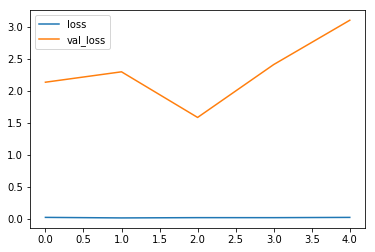

In [25]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.show()

The simpler model performs far better than the pre-trained models.

## Fine Tuning

After experimenting with different architectures, this one produced the best results:

In [16]:
def custom_model():
    
    x = Input((64, 64, 3))
    model = BatchNormalization(axis = 3)(x)
    model = Convolution2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', 
                          activation='elu', kernel_initializer='random_uniform',
                         bias_constraint=min_max_norm(min_value=0.0, max_value=2.0))(model)
    model = Convolution2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', 
                          activation='elu', kernel_initializer='random_uniform',
                         bias_constraint=min_max_norm(min_value=0.0, max_value=2.0))(model)
    model = MaxPooling2D()(model)
    model = Dropout(0.2)(model)
    
    model = BatchNormalization(axis = 3)(x)
    model = Convolution2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = 'same', 
                          activation='elu', kernel_initializer='random_uniform',
                         bias_constraint=min_max_norm(min_value=0.0, max_value=2.0))(model)
    model = Convolution2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = 'same', 
                          activation='elu', kernel_initializer='random_uniform',
                         bias_constraint=min_max_norm(min_value=0.0, max_value=2.0))(model)
    model = MaxPooling2D()(model)
    
    model = BatchNormalization(axis = 3)(model)
    model = Convolution2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = 'same', 
                          activation='elu', kernel_initializer='random_uniform',
                         bias_constraint=min_max_norm(min_value=0.0, max_value=2.0))(model)
    model = Convolution2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = 'same', 
                          activation='elu', kernel_initializer='random_uniform',
                         bias_constraint=min_max_norm(min_value=0.0, max_value=2.0))(model)
    model = MaxPooling2D()(model)
        
    model = BatchNormalization(axis = 3)(model)
    model = Convolution2D(filters = 512, kernel_size = (3,3), strides = (1,1), padding = 'same', 
                          activation='elu', kernel_initializer='random_uniform',
                         bias_constraint=min_max_norm(min_value=0.0, max_value=2.0))(model)
    model = Convolution2D(filters = 512, kernel_size = (3,3), strides = (1,1), padding = 'same', 
                          activation='elu', kernel_initializer='random_uniform',
                         bias_constraint=min_max_norm(min_value=0.0, max_value=2.0))(model)
    model = MaxPooling2D()(model)
    
    model = BatchNormalization(axis = 3)(model)
    model = Convolution2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = 'same', 
                          activation='elu', kernel_initializer='random_uniform',
                         bias_constraint=min_max_norm(min_value=0.0, max_value=2.0))(model)
    model = MaxPooling2D()(model)
    
    model = BatchNormalization(axis = 3)(model)
    model = Convolution2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = 'same', 
                          activation='elu', kernel_initializer='random_uniform',
                         bias_constraint=min_max_norm(min_value=0.0, max_value=2.0))(model)
    model = MaxPooling2D()(model)
    model = Dropout(0.2)(model)
    
    model = BatchNormalization(axis = 3)(model)
    model = Convolution2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', 
                          activation='elu', kernel_initializer='random_uniform',
                         bias_constraint=min_max_norm(min_value=0.0, max_value=2.0))(model)
    model = GlobalAveragePooling2D()(model)
    
    model = Dense(64, activation = 'elu')(model)
    model = Dense(NUM_CATEGORIES, activation = 'softmax')(model)
    model = Model(input = x, output = model)
    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), 
                  metrics=['accuracy'])
    
    return model

datagen = image.ImageDataGenerator(horizontal_flip=True, brightness_range = [0.5,2], zoom_range=0.2)
folds = k_fold(10)
model = custom_model()
for j, (train_idx, val_idx) in enumerate(folds):
    
    print('\nFold ',j)
    X_train_cv = X[train_idx]
    y_train_cv = y[train_idx]
    X_valid_cv = X[val_idx]
    y_valid_cv= y[val_idx]
    
    name_weights = "custom_model25_" + str(j) + "_weights.h5"
    callbacks = get_callbacks(name_weights = name_weights, patience_lr=9)
    
    generator = datagen.flow(X_train_cv, y_train_cv, batch_size = batch_size)
    
    model_history = model.fit_generator(
                generator,
                steps_per_epoch=len(X_train_cv)/batch_size,
                epochs=4,
                shuffle=True,
                verbose=1,
                validation_data = (X_valid_cv, y_valid_cv),
                callbacks = callbacks)
    
    print(model.evaluate(X_valid_cv, y_valid_cv))
    model.save("models/custom_model25_fold.h5")
model.save("models/custom_model25.h5")
print("Saved model to disk")

/home/isa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`



Fold  0


/home/isa/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/4
144/143 [==============================] - 2567s 18s/step - loss: 1.3422 - acc: 0.5286 - val_loss: 1.3475 - val_acc: 0.5609
Epoch 2/4
144/143 [==============================] - 2630s 18s/step - loss: 0.9613 - acc: 0.6651 - val_loss: 1.4248 - val_acc: 0.5618
Epoch 3/4
144/143 [==============================] - 2736s 19s/step - loss: 0.7668 - acc: 0.7359 - val_loss: 0.7135 - val_acc: 0.7653
Epoch 4/4
1027/1027 [==============================] - 92s 90ms/step
[0.8847180573594373, 0.7293086660175268]

Fold  1
Epoch 1/4
144/143 [==============================] - 2561s 18s/step - loss: 0.5475 - acc: 0.8137 - val_loss: 0.4998 - val_acc: 0.8372
Epoch 2/4
144/143 [==============================] - 2488s 17s/step - loss: 0.4565 - acc: 0.8486 - val_loss: 0.5889 - val_acc: 0.8129
Epoch 3/4
144/143 [==============================] - 2569s 18s/step - loss: 0.4231 - acc: 0.8567 - val_loss: 0.5294 - val_acc: 0.8353
Epoch 4/4
1026/1026 [==============================] - 81s 78ms/step
[0.67625

To improve validation accuracy, the following changes were made:

- Added droupout of 20% near the beginning and ending layers. Adding dropout to the middle layers produced worse results.

- Reduced the number of convolution layers. 

- Changed activation from relu to elu. 

- Set the kernel initializer to random uniform.

- Constrained the bias to the range 0 to 2.

- Trained model at 4 epochs per fold instead of the previous 5.


## Predict

In [14]:
test = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(test_dir, category)):
        test.append(['data/test/{}/{}'.format(category, file), category_id, category])
test = pd.DataFrame(test, columns=['file', 'category_id', 'category'])
test.head()

,file,category_id,category
0,data/test/altar/c077a7c3-a142-4f46-a2f2-c19f6d...,0,altar
1,data/test/altar/36240292170_1785911c19_m.jpg,0,altar
2,data/test/altar/35848005820_fcae5e9f1a_n.jpg,0,altar
3,data/test/altar/00947185-77b4-4ecf-85ed-bf139c...,0,altar
4,data/test/altar/791224e2-0980-4429-911b-802853...,0,altar


In [15]:
test.shape

(1404, 3)

In [16]:
X_test = []
y_test = test['category_id']
for filepath in test['file'].values:
    img=read_img(filepath, (64,64))
    X_test.append(img)

In [17]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [21]:
model = load_model("models/custom_model25.h5")
model.evaluate(x=X_test, y=y_test, batch_size=batch_size)

1404/1404 [==============================] - 112s 80ms/step


[0.36277917952958677, 0.9017094008603327]

90.17% accuracy